<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/reviews/analise_exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monta o google drive

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [41]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Baixe a lista de stopwords em português
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!pip install langdetect
from langdetect import detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=168b0e0f9de19b3f293cd9620aacba781e7f4022e7387e1457ad86683a190e3e
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


# Dados dos hoteis

In [3]:
date = "2023/02/15"

## Cria o DataFrame

### conferindo a versão do sns

In [4]:
sns.__version__

'0.12.2'

### carregando um unico arquivo

In [ ]:
filename = 'aram-beach-&-convention-gm-reviews.csv'
df = pd.read_csv(f"/content/gdrive/MyDrive/tcc/data/{date}/{filename}")
df['source'] = filename.split('.')[0]
df[:1]

,token,review_id,retrieval_date,rating,rating_max,relative_date,likes,other_ratings,trip_type_travel_group,user_name,user_is_local_guide,user_reviews,user_photos,user_url,text,response_text,response_relative_date,errors,source
0,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNob1lud2ZBEAE,2023-02-15 02:48:02.460131,5.0,5.0,5 horas atrás,-1,"Destaques do hotel Luxuoso, Vista linda e Tran...",Negócios | Amigos,Lucas Victor da Luz Cesar,True,21,12.0,https://www.google.com/maps/contrib/1109357607...,NaN,NaN,NaN,[],aram-beach-&-convention-gm-reviews.csv


### carregando todos os arquivos da pasta

In [5]:
import glob
import os

path_to_lookup = f'/content/gdrive/MyDrive/tcc/data/{date}/'
file_pattern = "*.csv"

# setting the path for joining multiple files
files = os.path.join(path_to_lookup, file_pattern)

# list of merged files returned
files = glob.glob(files)
print(len(set(files)))
df = pd.concat(map(lambda file: pd.read_csv(file).assign(source=file.split("/")[-1].split('-gm-reviews')[0]), files), ignore_index=True)
## VERIFICAR: sumiram/faltam dois arquivos?
len(set(df['source']))

68


66

### Tratando dataset

#### filtrando por avaliações com mais de 2 caracteres

In [6]:
initial_count = df.shape[0]
df = df[df['text'].notna()] 
df = df[df['text'].str.len() > 2] ## deveria filtrar por tamanho minimo de texto?
filtered_count = df.shape[0]
filtered_count

209904

#### quantidade total de reviews

In [7]:
initial_count ## reviews no total com e sem texto

332721

#### quantidade de reviews com 2 ou menos caracteres

In [8]:
initial_count - filtered_count ## reviews sem texto

122817

#### quantidade de reviews com mais de 2 caracteres

In [9]:
filtered_count ## reviews com texto

209904

#### preparando colunas

Transformamos a data relativa da realização do review em datetime e criamos novas colunas com partes dessa data e também quantidade de reviews de um usuario em um valor inteiro.

In [10]:
from datetime import datetime, timedelta
import re

def transform_user_reviews(x):
  if isinstance(x, str) and x == 'Um': 
    1
  elif isinstance(x, str):
    return int(x.replace('.',''))
  return x

# Função para detectar idioma, tratando valores nulos e textos vazios
def detectar_idioma(texto):
    if texto and len(texto) > 2:  # Verificar se o texto não é nulo e não está vazio
        try:
          lang = detect(texto)
          return lang
        except:
          print(f"deu ruim {texto}")

    return None

def obtem_data(row):
  # String de data relativa
  data_relativa_str = row.relative_date
  timestamp = row.retrieval_date
  
  # Converte a string em um objeto timedelta
  unidade_tempo = data_relativa_str.split()[1]
  quantidade_tempo = 1 if 'um' in data_relativa_str.split()[0] else int(data_relativa_str.split()[0])

  if 'segundo' in unidade_tempo:
      data_relativa = timedelta(seconds=quantidade_tempo)
  elif 'minuto' in unidade_tempo:
      data_relativa = timedelta(minutes=quantidade_tempo)
  elif 'hora' in unidade_tempo:
      data_relativa = timedelta(hours=quantidade_tempo)
  elif 'dia' in unidade_tempo:
      data_relativa = timedelta(days=quantidade_tempo)
  elif 'semana' in unidade_tempo:
      data_relativa = timedelta(weeks=quantidade_tempo)
  elif re.match(r"m(ê|e)s", unidade_tempo):
      data_relativa = timedelta(days=30*quantidade_tempo)
  elif 'ano' in unidade_tempo:
      data_relativa = timedelta(days=365*quantidade_tempo)
  else:
      return timestamp

  # Timestamp
  try:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
  except:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
  
  return (dt_timestamp - data_relativa).date()

2022    71301
2020    41920
2019    36218
2018    23437
2021    19784
2023     8410
2017     6823
2016     1200
2015      400
2014      275
2013      120
2012       10
2011        6
Name: ano_avaliacao, dtype: int64

In [11]:
df['user_reviews'] = df['user_reviews'].apply(transform_user_reviews).fillna(0)

df['data_avaliacao'] = pd.to_datetime(df.apply(obtem_data, axis=1))

# Extract month and year from the 'date' column
df['mes_avaliacao'] = df['data_avaliacao'].dt.month
df['ano_avaliacao'] = df['data_avaliacao'].dt.year

# Create a new column representing the combination of month and year
df['mes_ano_avaliacao'] = df['data_avaliacao'].dt.to_period('M')


# Aplica a função ao DataFrame e adiciona uma coluna com o resultado
df['idioma'] = df['text'].apply(detectar_idioma)

df['ano_avaliacao'].value_counts()

deu ruim ÓTIMO
deu ruim ...........
deu ruim ÓTIMO
deu ruim ÓTIMO
deu ruim ÓTIMO
deu ruim ÓTIMA
deu ruim ÓTIMA
deu ruim 10/10
deu ruim ÓTIMO
deu ruim 10/10
deu ruim ÓTIMA
deu ruim ÓTIMO
deu ruim ÓTIMA
deu ruim 10/10
deu ruim :) :)
deu ruim 0/-10
deu ruim ÓTIMA
deu ruim 10000/10
deu ruim 10/10
deu ruim ÓTIMO


,token,review_id,retrieval_date,rating,rating_max,relative_date,likes,other_ratings,trip_type_travel_group,user_name,...,text,response_text,response_relative_date,errors,source,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,idioma
0,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNoNFlDWlB3EAE,2023-02-15 02:48:01.831814,4.0,5.0,2 horas atrás,0,Quartos : 3/5 | Serviço : 5/5 | Local : 4/5 De...,Férias | Família,Roberto Pavani,...,"A parte de lazer, especialmente para crianças,...",NaN,NaN,[],cassino-all-inclusive-resort-poços,2023-02-15,2,2023,2023-02,pt
1,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNoZ2ZYMlFnEAE,2023-02-15 02:48:01.836818,5.0,5.0,12 horas atrás,0,Quartos : 5/5 | Serviço : 5/5 | Local : 5/5,NaN,Emerson Fructuoso,...,Muito bom.,"Olá, Sr. Emerson! Obrigado por avaliar o Cassi...",7 horas atrás,[],cassino-all-inclusive-resort-poços,2023-02-14,2,2023,2023-02,pt
2,CAESBkVnSUlDZw==,ChdDSUhNMG9nS0VJQ0FnSUNoX3EydXBRRRAB,2023-02-15 02:48:01.839825,4.0,5.0,16 horas atrás,0,Quartos : 5/5 | Serviço : 4/5 | Local : 4/5,NaN,GILBERTO ELPES,...,Precisa somente de alguma reformas em mesas de...,"Olá, Sr. Gilberto! Obrigado pela gentileza em ...",7 horas atrás,[],cassino-all-inclusive-resort-poços,2023-02-14,2,2023,2023-02,pt
3,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNoM3NXMGV3EAE,2023-02-15 02:48:01.842919,5.0,5.0,um dia atrás,0,NaN,NaN,Ingrid Sobrinho,...,Que experiência incrível !!!!! Eu queria muito...,"Olá, Sra. Ingrid! Obrigado por avaliar o Cassi...",7 horas atrás,[],cassino-all-inclusive-resort-poços,2023-02-14,2,2023,2023-02,pt
4,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNobm9xT0lnEAE,2023-02-15 02:48:01.847158,3.0,5.0,um dia atrás,0,Quartos : 3/5 | Serviço : 3/5 | Local : 3/5,Férias | Família,Elaine pasin,...,O espaço é grande é diferente. Mas falta manut...,"Olá, Sra. Elaine! Obrigado pela gentileza em n...",7 horas atrás,[],cassino-all-inclusive-resort-poços,2023-02-14,2,2023,2023-02,pt


In [ ]:
df.head()

### analise exploratoria

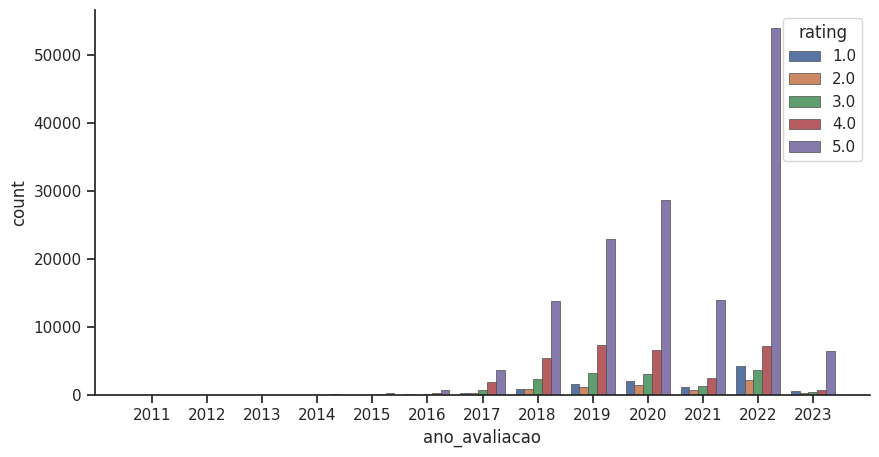

In [15]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="ticks")
sns.despine(f)

sns.countplot(
    x="ano_avaliacao",
    hue="rating",
    data=df,
    edgecolor=".3",
    linewidth=.5,
)
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.autoscale()
plt.show()

<Axes: xlabel='rating', ylabel='count'>

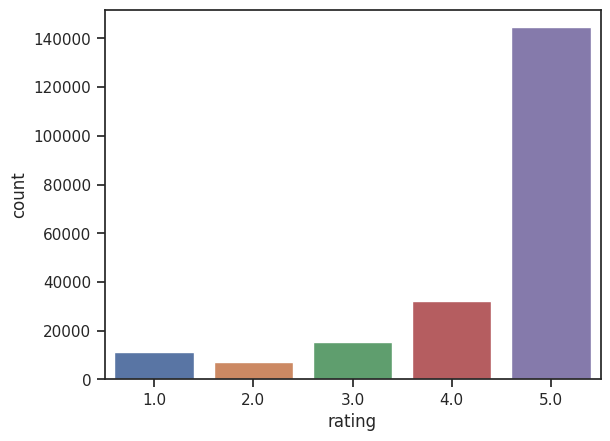

In [16]:
sns.countplot(x="rating", data=df)

In [17]:
df[['source', 'rating']].groupby(['source']).size().reset_index(name='counts').sort_values("counts", ascending=False).head(10)

,source,counts
52,pratagy-beach-all-inclusive-resort-maceió---w...,19776
14,grand-palladium-imbassaí-resort-&-spa,15827
5,costão-do-santinho-resort-all-inclusive,10514
41,iberostar-bahia,10044
61,serhs-natal-grand-hotel-&-resort,8127
60,sauípe-premium-brisa---all-inclusive,7532
3,cana-brava-all-inclusive-resort,7365
53,prive-riviera-park-hotel,6557
43,iberostar-selection-praia-do-forte,5487
10,golden-dolphin-grand-hotel---central-de-reservas,5473


In [16]:
df.describe()

,rating,rating_max,user_photos,mes_avaliacao,ano_avaliacao
count,209904.000000,209904.0,117682.000000,209904.000000,209904.000000
mean,4.392117,5.0,68.638948,2.885362,2020.355548
std,1.102000,0.0,141.709507,2.362166,1.678854
min,1.000000,5.0,1.000000,1.000000,2011.000000
25%,4.000000,5.0,3.000000,2.000000,2019.000000
50%,5.000000,5.0,13.000000,2.000000,2020.000000
75%,5.000000,5.0,58.000000,2.000000,2022.000000
max,5.000000,5.0,999.000000,12.000000,2023.000000


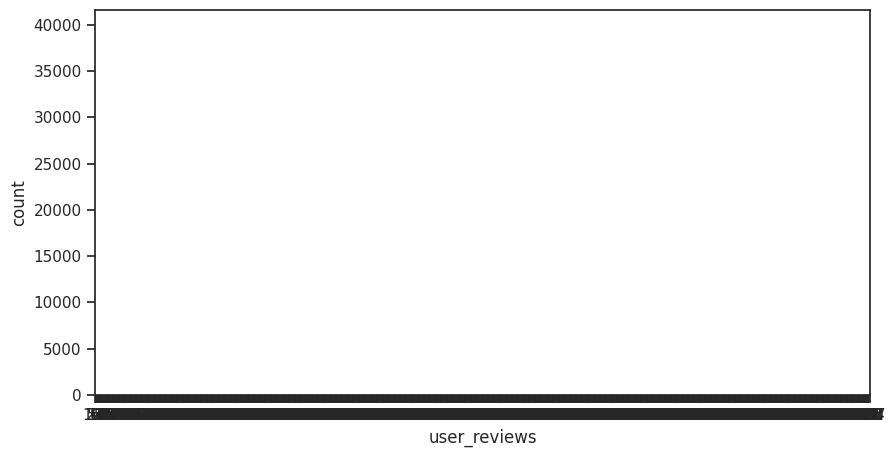

In [20]:
## quantidade de reviews por usuario

## diminuir a quantidade de valores analisados TODO
## grafico de cima est'a estragando a escala aqui TODO
plt.figure(figsize=(10,5))
sns.countplot(x='user_reviews', data=df)
plt.show()

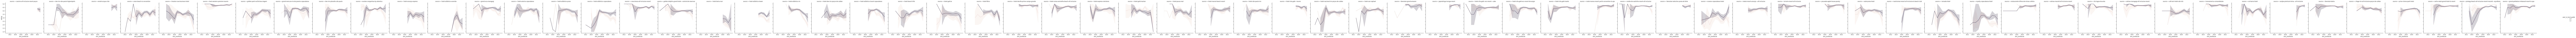

In [ ]:
## n~ao funciona legal com muitos sources

sns.relplot(
    x='ano_avaliacao', 
    y='rating', 
    col='source',
    hue='user_is_local_guide',
    kind="line",
    data=df
)

In [ ]:
df[['rating', 'text', 'data_avaliacao', 'user_is_local_guide', 'user_reviews']].head()

,rating,text,data_avaliacao,user_is_local_guide,user_reviews
0,4.0,"A parte de lazer, especialmente para crianças,...",2023-02-15,True,24
1,5.0,Muito bom.,2023-02-14,True,54
2,4.0,Precisa somente de alguma reformas em mesas de...,2023-02-14,True,167
3,5.0,Que experiência incrível !!!!! Eu queria muito...,2023-02-14,False,7
4,3.0,O espaço é grande é diferente. Mas falta manut...,2023-02-14,False,8


<Figure size 1000x500 with 0 Axes>

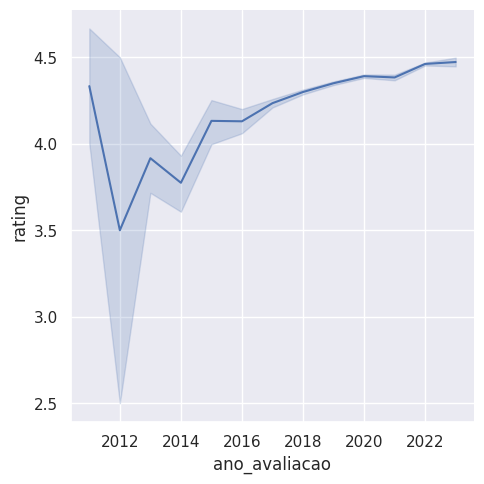

In [68]:
plt.figure(figsize=(10,5))
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=df)

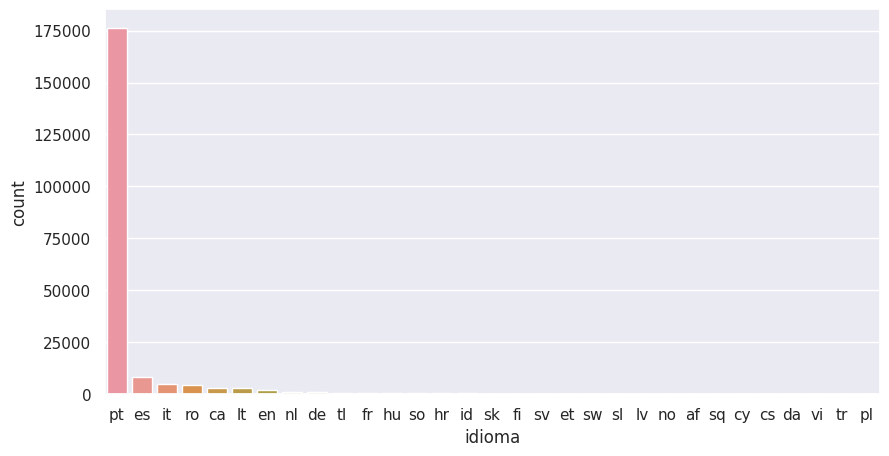

In [66]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,5))
sns.countplot(x='idioma', 
              data=df, 
              order = df['idioma'].value_counts().index)
plt.show()

In [49]:
dfpt = df[df['idioma'].apply(lambda x: False if x is None else 'pt' not in x)]

dfpt

,token,review_id,retrieval_date,rating,rating_max,relative_date,likes,other_ratings,trip_type_travel_group,user_name,...,text,response_text,response_relative_date,errors,source,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,idioma
20,CAESBkVnSUlIZw==,ChdDSUhNMG9nS0VJQ0FnSUNoLU1EMHlnRRAB,2023-02-15 02:48:03.364607,5.0,5.0,uma semana atrás,0,Quartos : 4/5 | Serviço : 5/5 | Local : 5/5,Férias,Andre Dias,...,Ótimo atendimento do Vanderson.,"Olá, Sr. André! Obrigado por nos avaliar. Fica...",uma semana atrás,[],cassino-all-inclusive-resort-poços,2023-02-08,2,2023,2023-02,it
21,CAESBkVnSUlIZw==,ChdDSUhNMG9nS0VJQ0FnSUNodU5YYzVnRRAB,2023-02-15 02:48:03.370284,5.0,5.0,uma semana atrás,0,Quartos : 4/5 | Serviço : 5/5 | Local : 5/5,Família,Dri Diniz,...,"Ótima comida, ótimo atendimento, muito lazer","Olá, Sra. Dri! Obrigado por avaliar o Cassino ...",3 dias atrás,[],cassino-all-inclusive-resort-poços,2023-02-08,2,2023,2023-02,it
36,CAESBkVnSUlLQQ==,ChZDSUhNMG9nS0VJQ0FnSURCcjhPUkNnEAE,2023-02-15 02:48:04.225283,5.0,5.0,2 semanas atrás,0,Quartos : 5/5 | Serviço : 5/5 | Local : 4/5,Férias | Família,Fabiana Cotini,...,Excelente,"Olá, Sra. Fabiana! Obrigado por avaliar o Cass...",uma semana atrás,[],cassino-all-inclusive-resort-poços,2023-02-01,2,2023,2023-02,ro
38,CAESBkVnSUlLQQ==,ChZDSUhNMG9nS0VJQ0FnSURCcjRMZlF3EAE,2023-02-15 02:48:04.278685,5.0,5.0,2 semanas atrás,0,Quartos : 4/5 | Serviço : 4/5 | Local : 4/5,Casal,Vinicius Botelho Cavalheiro,...,Ótima,"Olá, Sr. Vinicius Obrigado por avaliar o Cassi...",uma semana atrás,[],cassino-all-inclusive-resort-poços,2023-02-01,2,2023,2023-02,lt
50,CAESBkVnSUlQQQ==,ChdDSUhNMG9nS0VJQ0FnSURCLTk3cXhBRRAB,2023-02-15 02:48:05.576486,5.0,5.0,2 semanas atrás,0,Quartos : 5/5 | Serviço : 5/5 | Local : 5/5,Família,Baltazar Souza,...,Excelente,"Olá, Sr.Baltazar! Obrigado por avaliar o Cassi...",2 semanas atrás,[],cassino-all-inclusive-resort-poços,2023-02-01,2,2023,2023-02,ro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332691,CAESCEVnUUl4cVVC,ChdDSUhNMG9nS0VJQ0FnSURRNk9HRnh3RRAB,2023-02-15 05:52:42.339645,5.0,5.0,8 anos atrás,0,NaN,NaN,Ela ne Eunaldo,...,Muito bommmm. Que pena que já está acabando.,NaN,NaN,[],grand-palladium-imbassaí-resort-&-spa,2015-02-17,2,2015,2015-02,es
332706,CAESCEVnUUkycVVC,ChdDSUhNMG9nS0VJQ0FnSUNBa1ptaGhnRRAB,2023-02-15 05:54:56.222711,5.0,5.0,9 anos atrás,0,NaN,NaN,Edmar Jesus,...,Que pena que duro pouco,NaN,NaN,[],grand-palladium-imbassaí-resort-&-spa,2014-02-17,2,2014,2014-02,es
332709,CAESCEVnUUkycVVC,ChZDSUhNMG9nS0VJQ0FnSUNBeE5HREpBEAE,2023-02-15 05:54:56.231013,5.0,5.0,9 anos atrás,0,NaN,NaN,Angel Rojas,...,Excelente,NaN,NaN,[],grand-palladium-imbassaí-resort-&-spa,2014-02-17,2,2014,2014-02,ro
332713,CAESCEVnUUkycVVC,ChZDSUhNMG9nS0VJQ0FnSURBNjhMQ0hnEAE,2023-02-15 05:54:56.242323,5.0,5.0,9 anos atrás,0,NaN,NaN,Charly,...,Excelente lugar!!,NaN,NaN,[],grand-palladium-imbassaí-resort-&-spa,2014-02-17,2,2014,2014-02,ro


In [65]:
from langdetect import DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
DetectorFactory.seed = 38  ## deveria utilizar seed fixa?
for x in range(10):
  print(f"1 {detect('ótimo')}")
DetectorFactory.seed = 383 ## deveria utilizar seed fixa?
for x in range(10):
  print(f"1 {detect('ótimo')}")

1 es
1 es
1 es
1 es
1 es
1 es
1 es
1 es
1 es
1 es
1 hu
1 hu
1 hu
1 hu
1 hu
1 hu
1 hu
1 hu
1 hu
1 hu


In [63]:
### existe biblioteca melhor?
for x in range(10):
  print(f"1 {detect('Satisfeito')}")
for x in range(10):
  print(f"2 {detect('Satisfeito.')}")
for x in range(10):
  print(f"3 {detect('satisfeito')}")
for x in range(10):
  print(f"4 {detect('satisfeito.')}")

1 de
1 de
1 de
1 de
1 de
1 de
1 de
1 de
1 de
1 de
2 it
2 it
2 it
2 it
2 it
2 it
2 it
2 it
2 it
2 it
3 fi
3 fi
3 fi
3 fi
3 fi
3 fi
3 fi
3 fi
3 fi
3 fi
4 it
4 it
4 it
4 it
4 it
4 it
4 it
4 it
4 it
4 it


In [64]:
### existe/preciso de biblioteca melhor?
for x in range(10):
  print(f"2 {detect('ótimo')}")
for x in range(10):
  print(f"1 {detect('ÓTIMO')}")

2 lt
2 hu
2 lt
2 it
2 lt
2 lt
2 lt
2 lt
2 hu
2 lt


LangDetectException: ignored

In [48]:
## 20646 como tratar essa galera? 66 hoteis / freq 4116 grand-palladium-imbassaí-resort-&-spa sem considerar a identificação do idioma

df[df['text'].str.contains('Tradução do Google')].describe()

,rating,rating_max,user_photos,mes_avaliacao,ano_avaliacao
count,20646.000000,20646.0,13236.000000,20646.000000,20646.000000
mean,4.351158,5.0,84.290715,2.756660,2019.875133
std,1.097965,0.0,156.764769,2.284992,1.744994
min,1.000000,5.0,1.000000,1.000000,2011.000000
25%,4.000000,5.0,4.000000,2.000000,2019.000000
50%,5.000000,5.0,19.000000,2.000000,2020.000000
75%,5.000000,5.0,81.000000,2.000000,2022.000000
max,5.000000,5.0,999.000000,12.000000,2023.000000


In [36]:
a = df[df['idioma'] == 'pt']
a.describe()

,rating,rating_max,user_photos,mes_avaliacao,ano_avaliacao
count,176426.000000,176426.0,98353.000000,176426.000000,176426.000000
mean,4.343243,5.0,69.106937,2.941080,2020.406754
std,1.140277,0.0,142.609829,2.427093,1.687263
min,1.000000,5.0,1.000000,1.000000,2011.000000
25%,4.000000,5.0,3.000000,2.000000,2019.000000
50%,5.000000,5.0,13.000000,2.000000,2020.000000
75%,5.000000,5.0,58.000000,2.000000,2022.000000
max,5.000000,5.0,999.000000,12.000000,2023.000000


In [37]:
trad = a[df['text'].str.contains('Tradução do Google')] 
trad.describe()

<ipython-input-37-de8d22e82c18>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trad = a[df['text'].str.contains('Tradução do Google')]


,rating,rating_max,user_photos,mes_avaliacao,ano_avaliacao
count,17896.000000,17896.0,11472.000000,17896.000000,17896.00000
mean,4.390925,5.0,84.139057,2.723122,2019.83840
std,1.059796,0.0,157.637710,2.239665,1.73485
min,1.000000,5.0,1.000000,1.000000,2011.00000
25%,4.000000,5.0,4.000000,2.000000,2019.00000
50%,5.000000,5.0,19.000000,2.000000,2020.00000
75%,5.000000,5.0,79.000000,2.000000,2022.00000
max,5.000000,5.0,999.000000,12.000000,2023.00000


In [32]:
## deveriam ser removidos?
trad[['text']] 

,text
51,Top (Tradução do Google) Principal Quartos : 4...
140,They claim to be a pet friendly resort but it ...
177,(Tradução do Google) O período (Original) Ajak...
284,Top (Tradução do Google) Principal
418,TOP (Tradução do Google) PRINCIPAL Quartos : 5...
...,...
332678,(Tradução do Google) Hotel muito bom! (Origina...
332688,(Tradução do Google) Excelente para férias com...
332689,(Tradução do Google) Mágico!! (Original) Mágic...
332707,"(Tradução do Google) Espetacular, o único pont..."


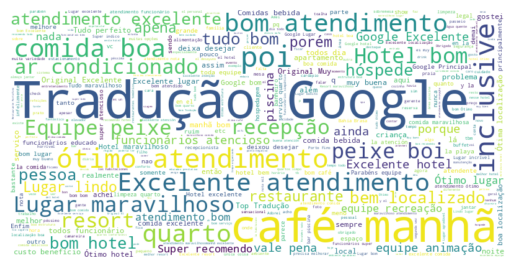

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

# Concatenar todos os textos em uma única string
texto = ' '.join(df['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)

# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

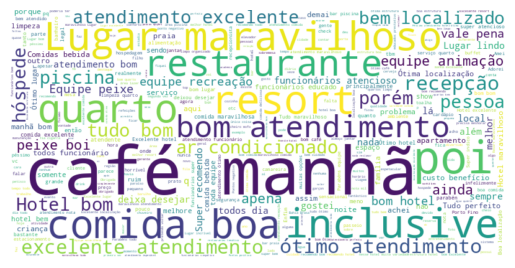

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
filtro = ~a['text'].str.contains('Tradução do Google')
text = a[filtro]

# Concatenar todos os textos em uma única string
texto = ' '.join(text['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)

# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

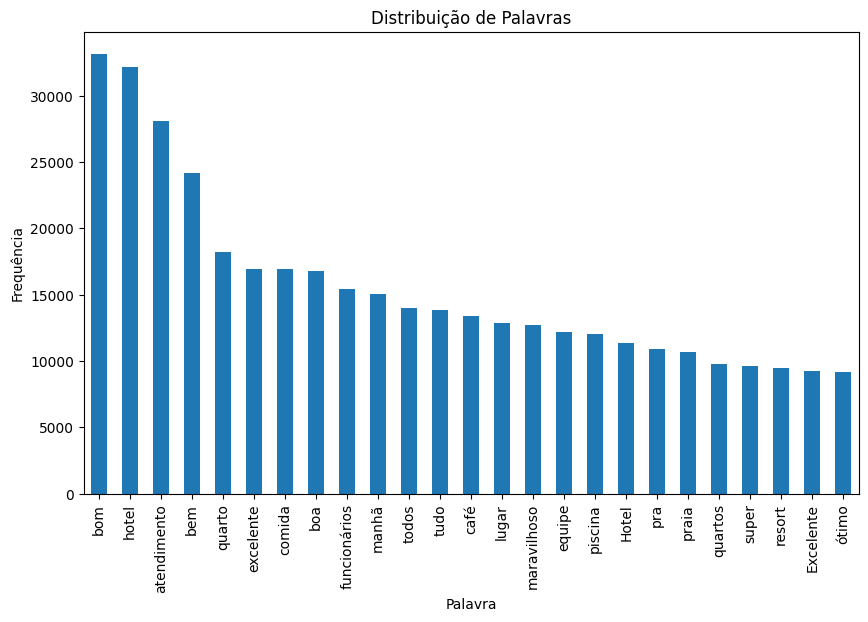

In [47]:
# Dividir a string em palavras
palavras = texto_sem_stopwords.split()

# Contar as ocorrências de cada palavra
contagem = pd.Series(palavras).value_counts().head(25)

# Criar um gráfico de barras para visualizar a distribuição de palavras
contagem.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Distribuição de Palavras')
plt.show()